In [17]:
import pandas as pd
import time
import numpy as np
import scipy
import scipy.stats as st
from scipy.stats import skewnorm
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)

import warnings

from scipy import stats  

%matplotlib inline

pd.options.display.max_columns = 80

In [3]:
trips = pd.read_csv('/home/emma/ual_model_workspace/fall-2018-models/trips_121218.csv')

In [4]:
trips02 = trips.loc[trips['TOD'].isin([2])]
trips03 = trips.loc[trips['TOD'].isin([3])]
trips12 = trips.loc[trips['TOD'].isin([12])]
trips13 = trips.loc[trips['TOD'].isin([13])]
trips14 = trips.loc[trips['TOD'].isin([14])]
trips22 = trips.loc[trips['TOD'].isin([22])]
trips23 = trips.loc[trips['TOD'].isin([23])]
trips24 = trips.loc[trips['TOD'].isin([24])]

In [28]:
HW = trips.HW_trip_ST
WH = trips.WH_trip_ST

In [379]:
trips24a = trips24.loc[(trips24['HW_trip_ST'] < 12)]
trips24b = trips24.loc[(trips24['HW_trip_ST'] >=12)]

In [439]:
print (len(trips24))
print (len(trips24a))
print (len(trips24b))

print (len(trips24a)/(len(trips24a)+len(trips24b)))
print (len(trips24b)/(len(trips24a)+len(trips24b)))

377
241
136
0.6392572944297082
0.36074270557029176


In [318]:
trips14.loc[ (trips14['WH_trip_ST'] < 5),
    'WH_trip_ST'] = trips14['WH_trip_ST'] + 24

trips24.loc[ (trips24['WH_trip_ST'] < 5),
    'WH_trip_ST'] = trips24['WH_trip_ST'] + 24

/home/emma/anaconda/envs/ual-model/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [380]:
HW02 = trips02.HW_trip_ST
HW03 = trips03.HW_trip_ST
HW12 = trips12.HW_trip_ST
HW13 = trips13.HW_trip_ST
HW14 = trips14.HW_trip_ST
HW22 = trips22.HW_trip_ST
HW23 = trips23.HW_trip_ST
HW24 = trips24.HW_trip_ST

HW24a = trips24a.HW_trip_ST
HW24b = trips24b.HW_trip_ST

WH02 = trips02.WH_trip_ST
WH03 = trips03.WH_trip_ST
WH12 = trips12.WH_trip_ST
WH13 = trips13.WH_trip_ST
WH14 = trips14.WH_trip_ST
WH22 = trips22.WH_trip_ST
WH23 = trips23.WH_trip_ST
WH24 = trips24.WH_trip_ST

In [253]:
# Create models from data
def best_fit_distribution1(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
        st.norm, st.skewnorm,
        st.alpha,st.anglit,st.argus,st.betaprime,st.burr,st.burr12,st.cauchy,
        st.chi,st.chi2,
        st.cosine,
        st.erlang,
        st.exponnorm,
        st.exponweib,st.exponpow,st.f,st.fisk
        
        
#         st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.gennorm,
#         st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.gilbrat,st.gumbel_r,
#         st.gumbel_l,st.hypsecant,st.invgamma,st.invgauss
        
#         st.johnsonsb, st.johnsonsu,st.ksone,st.logistic,st.loggamma,st.lognorm,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf
        
#         st.nct,st.pearson3,st.powerlognorm,st.powernorm,
#         st.rayleigh,st.rice,st.recipinvgauss,st.t,
#         st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max
        
        
#         st.arcsine,st.beta,st.bradford,st.dgamma,st.dweibull,st.expon,st.fatiguelife,st.foldcauchy,
#         st.genpareto,st.genexpon,st.genhalflogistic,st.gompertz,st.halfcauchy,st.halflogistic
        
#         st.halfnorm,st.halfgennorm,st.kappa3,st.laplace,st.levy,st.levy_l,st.levy_stable,st.loglaplace,
#         st.lomax,st.pareto,st.powerlaw,st.rdist,st.kappa4,st.invweibull
        
#         st.reciprocal,st.semicircular,st.trapz,st.triang,
#         st.truncexpon,st.truncnorm,st.tukeylambda,st.wrapcauchy
        
        
#         st.crystalball,st.kstwobign
        
        
#         st.burr12,st.cauchy,st.johnsonsu,st.t,st.tukeylambda,st.loglaplace,st.laplace,st.foldcauchy
        
       
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)


def make_pdf(dist, params, size=10000):
    """Generate distributions' Probability Distribution Functions """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.001, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [412]:
def best_fit_distribution2(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
        st.gausshyper,
        st.foldnorm,st.weibull_min,st.weibull_max,st.genlogistic,
        st.gennorm,
        st.genextreme,st.gamma,st.gengamma,st.gilbrat,st.gumbel_r,
        st.gumbel_l,st.hypsecant,st.invgamma,st.invgauss]

    # Best holders
    best_distribution = st.foldnorm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

In [8]:
# Create models from data
def best_fit_distribution3(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  

        st.johnsonsb, st.johnsonsu,st.ksone,st.logistic,st.loggamma,st.lognorm,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf
        
    ]

    # Best holders
    best_distribution = st.johnsonsu
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

In [9]:
# Create models from data
def best_fit_distribution4(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
 
        st.nct,st.pearson3,st.powerlognorm,st.powernorm,
        st.rayleigh,st.rice,st.recipinvgauss,st.t,
        st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max
    
    ]

    # Best holders
    best_distribution = st.t
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

In [103]:
# Create models from data
def best_fit_distribution5(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  

        st.gompertz,
        st.arcsine,st.beta,st.bradford,st.dgamma,st.dweibull,st.expon,st.fatiguelife,st.foldcauchy,
        st.genpareto,st.genexpon,st.genhalflogistic,st.halfcauchy,st.halflogistic

    ]

    # Best holders
    best_distribution = st.foldcauchy
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

In [118]:
# Create models from data
def best_fit_distribution6(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  

        st.semicircular,
        st.halfnorm,st.halfgennorm,st.kappa3,st.laplace,st.levy,st.levy_l,st.levy_stable,st.loglaplace,
        st.lomax,st.pareto,st.powerlaw,st.rdist,st.kappa4,st.invweibull,
        
        st.reciprocal,st.trapz,st.triang,
        st.truncexpon,st.truncnorm,st.tukeylambda,st.wrapcauchy
        
        
#         st.crystalball,st.kstwobign        
    ]

    # Best holders
    best_distribution = st.loglaplace
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

In [12]:
def make_pdf(dist, params, size=10000):
    """Generate distributions' Probability Distribution Functions """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.001, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [26]:
#For HW
def best_fit_distribution7(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
        
        st.burr12, st.skewnorm, st.cauchy, st.johnsonsu, st.dweibull,
        st.loglaplace,st.laplace, st.tukeylambda, st.gennorm, st.nct,st.foldcauchy
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

Text(0,0.5,'Frequency')

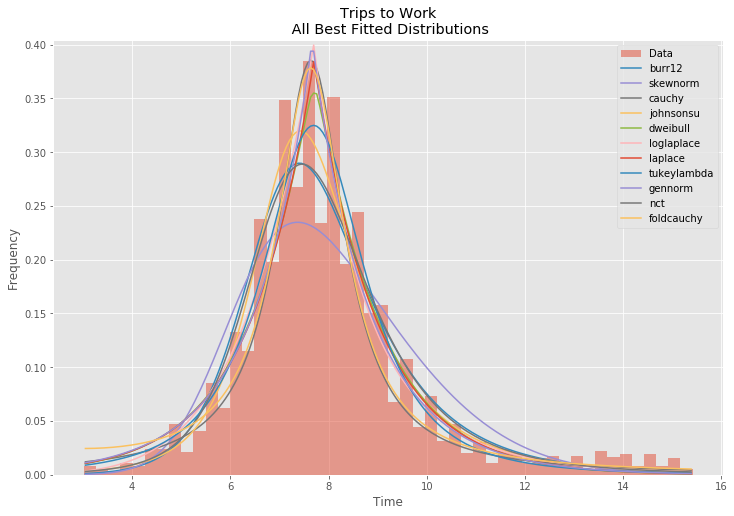

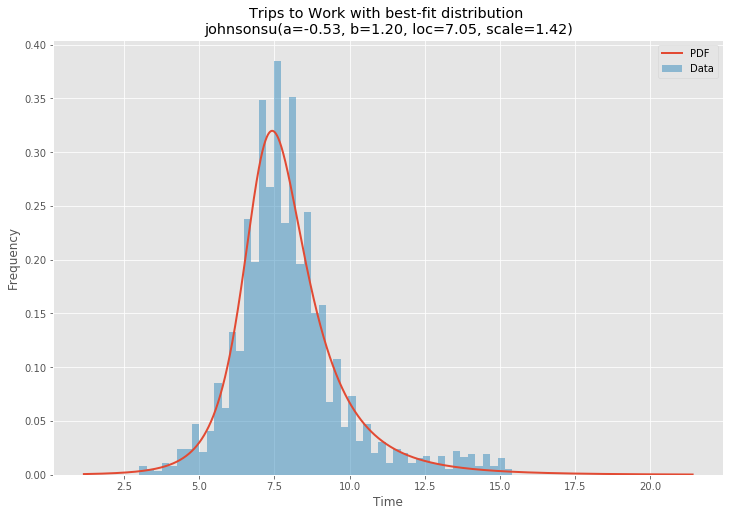

In [37]:
# # Load data
data = HW

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution7(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Trips to Work with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [50]:
#For WH
def best_fit_distribution8(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
        
        st.gennorm, 
        st.laplace, 
        st.burr, st.cauchy, st.johnsonsu, st.genlogistic, 
        st.loglaplace, st.tukeylambda, st.nct,st.foldcauchy
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

Text(0,0.5,'Frequency')

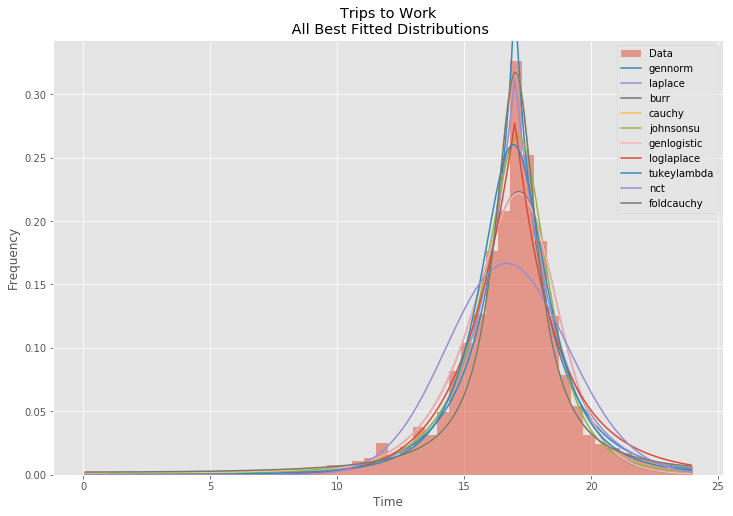

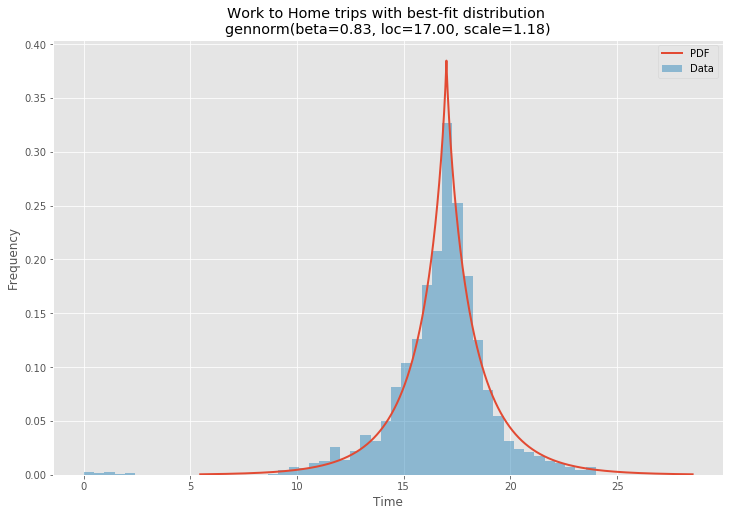

In [51]:
# # Load data
data = WH

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution8(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Work to Home trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For HW02
def best_fit_distribution9(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
        
        st.burr,st.gengamma,st.genlogistic,st.loggamma,st.mielke,
        st.johnsonsb,st.pearson3,st.weibull_max,st.beta,st.levy_l
        
#         st.gennorm, 
#         st.laplace, 
#         st.burr, st.cauchy, st.johnsonsu,  
#         st.loglaplace, st.tukeylambda, st.nct,st.foldcauchy
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

Text(0,0.5,'Frequency')

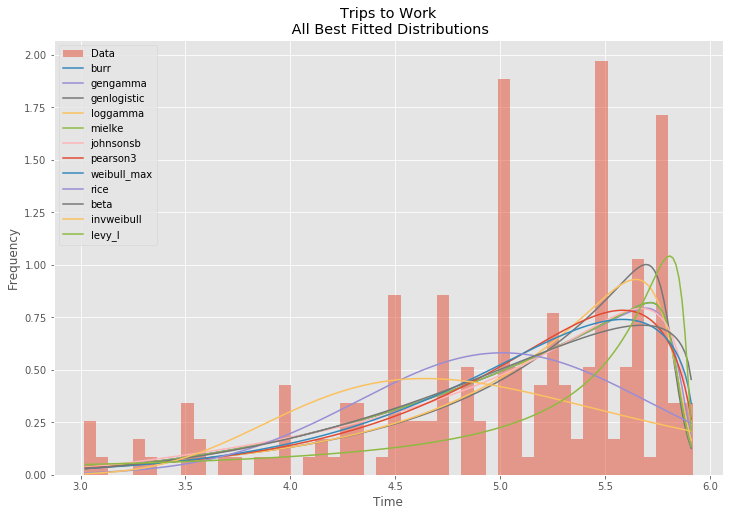

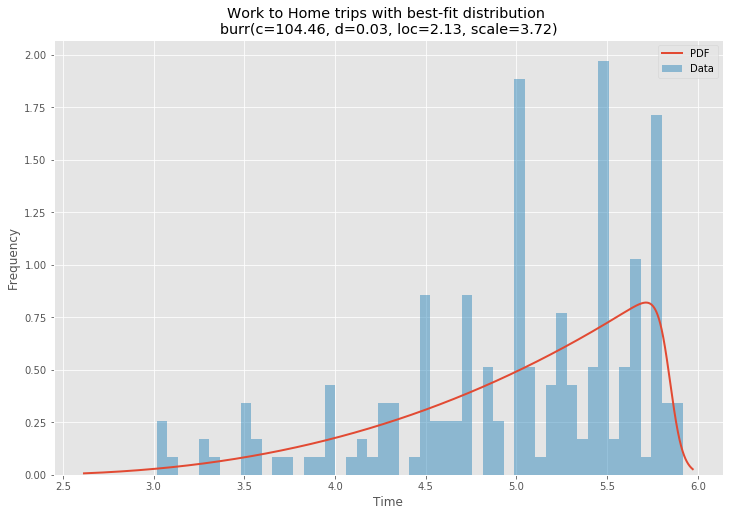

In [60]:
# # Load data
data = HW02

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution9(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'HW02 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For HW03
def best_fit_distribution10(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
        
        st.genlogistic,
        st.mielke,st.burr,
        st.pearson3,st.beta,
        st.gengamma,st.loggamma,st.johnsonsb,st.weibull_max
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

Text(0,0.5,'Frequency')

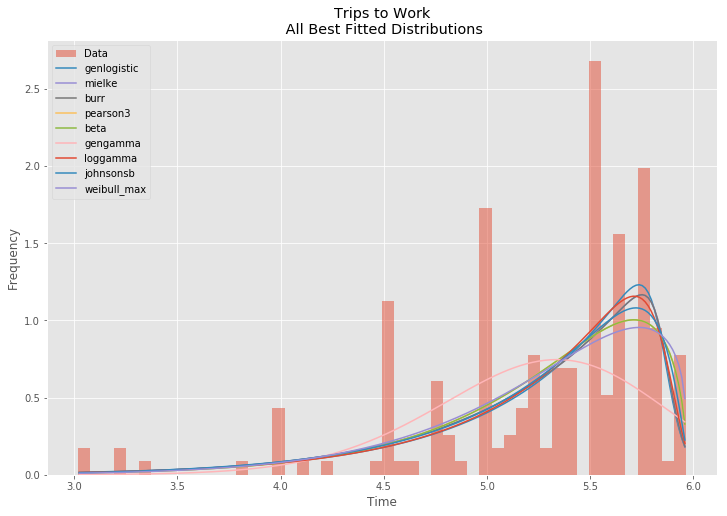

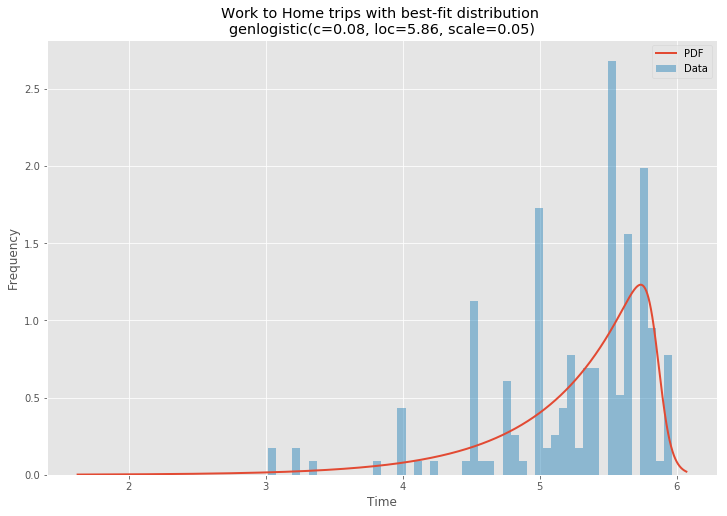

In [74]:
# # Load data
data = HW03

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution10(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'HW03 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

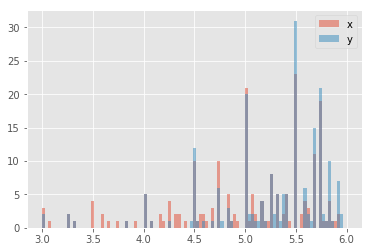

<Figure size 1440x864 with 0 Axes>

In [81]:
x = HW02
y = HW03

bins = np.linspace(3, 6, 100)

plt.hist(x, bins, alpha=0.5, label='HW02')
plt.hist(y, bins, alpha=0.5, label='HW03')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

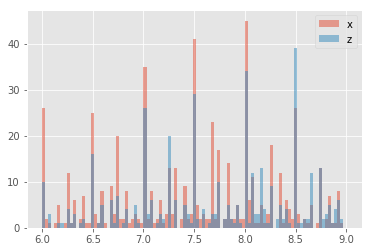

<Figure size 1440x864 with 0 Axes>

In [84]:
x = HW12
# y = HW13
z = HW14

bins = np.linspace(6, 9, 100)

plt.hist(x, bins, alpha=0.5, label='HW12')
# plt.hist(y, bins, alpha=0.5, label='HW13')
plt.hist(z, bins, alpha=0.5, label='HW14')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

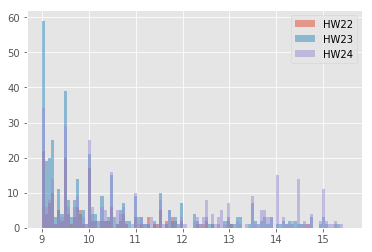

<Figure size 1440x864 with 0 Axes>

In [89]:
x = HW22
y = HW23
z = HW24

bins = np.linspace(9, 15.5, 100)

plt.hist(x, bins, alpha=0.5, label='HW22')
plt.hist(y, bins, alpha=0.5, label='HW23')
plt.hist(z, bins, alpha=0.5, label='HW24')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

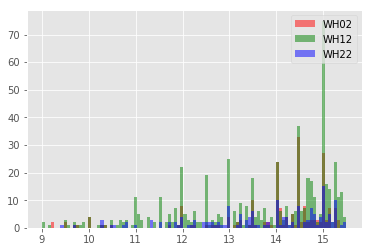

<Figure size 1440x864 with 0 Axes>

In [227]:
x = WH02
y = WH12
z = WH22

bins = np.linspace(9, 15.5, 100)

plt.hist(x, bins, alpha=0.5, label='WH02',color='red')
plt.hist(y, bins, alpha=0.5, label='WH12',color='green')
plt.hist(z, bins, alpha=0.5, label='WH22',color='blue')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

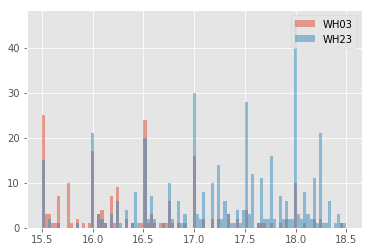

<Figure size 1440x864 with 0 Axes>

In [91]:
x = WH03
# y = WH13
z = WH23

bins = np.linspace(15.5, 18.5, 100)

plt.hist(x, bins, alpha=0.5, label='WH03')
# plt.hist(y, bins, alpha=0.5, label='WH13')
plt.hist(z, bins, alpha=0.5, label='WH23')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

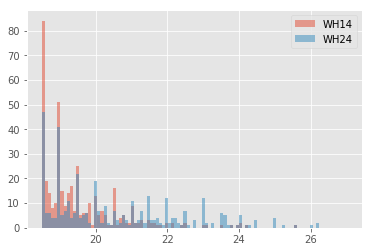

<Figure size 1440x864 with 0 Axes>

In [320]:
x = WH14
y = WH24

bins = np.linspace(18.5, 27, 100)

plt.hist(x, bins, alpha=0.5, label='WH14')
plt.hist(y, bins, alpha=0.5, label='WH24')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

In [ ]:
#For HW12
def best_fit_distribution12(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
        
        st.anglit,
        st.gausshyper,
        st.weibull_max,
        st.johnsonsb,
        st.mielke,
        st.vonmises_line,
        st.gompertz,
        st.semicircular,
        
        st.genlogistic,
        st.burr,
        st.pearson3,st.beta,
        st.gengamma,st.loggamma
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

Text(0,0.5,'Frequency')

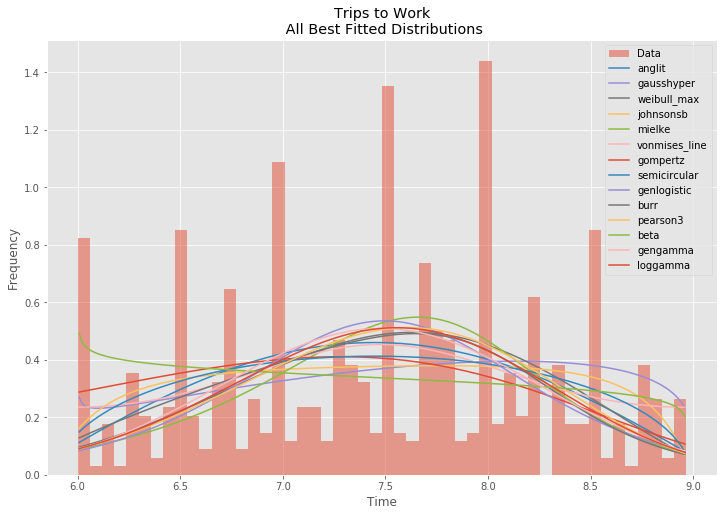

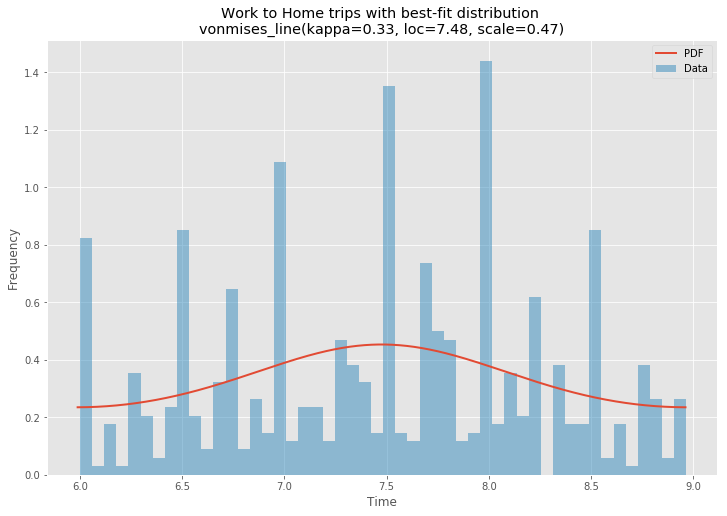

In [111]:
# # Load data
data = HW12

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution12(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'HW12 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For HW13
def best_fit_distribution13(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
        
#         st.gausshyper,        
        st.anglit,
        st.weibull_max,
        st.johnsonsb,
        st.mielke,
        st.vonmises_line,
        st.gompertz,
        st.semicircular,
        st.triang,
        
        st.genlogistic,
        st.burr,
        st.pearson3,st.beta,
        st.gengamma,st.loggamma
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

Text(0,0.5,'Frequency')

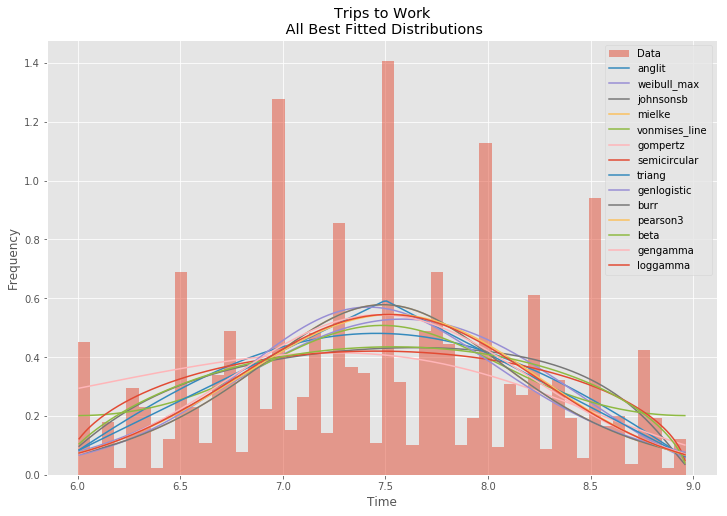

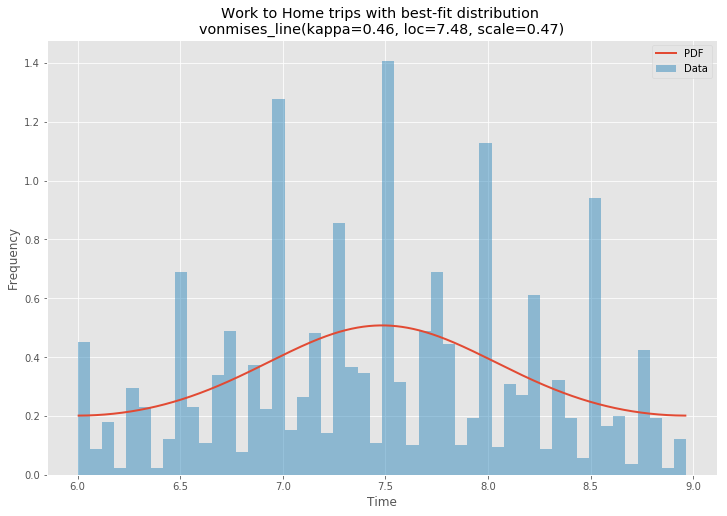

In [123]:
# # Load data
data = HW13

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution13(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'HW13 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For HW14
def best_fit_distribution14(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
        st.beta,
        st.exponweib,
        st.johnsonsb,
#         st.gausshyper,        
#         st.anglit,
#         st.weibull_max,
#         st.mielke,
#         st.vonmises_line,
#         st.gompertz,
#         st.fatiguelife,
#         st.semicircular,
#         st.triang,
#         st.powerlaw,
        
#         st.genlogistic,
#         st.burr,
#         st.pearson3,
#         st.gengamma,st.loggamma
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

Text(0,0.5,'Frequency')

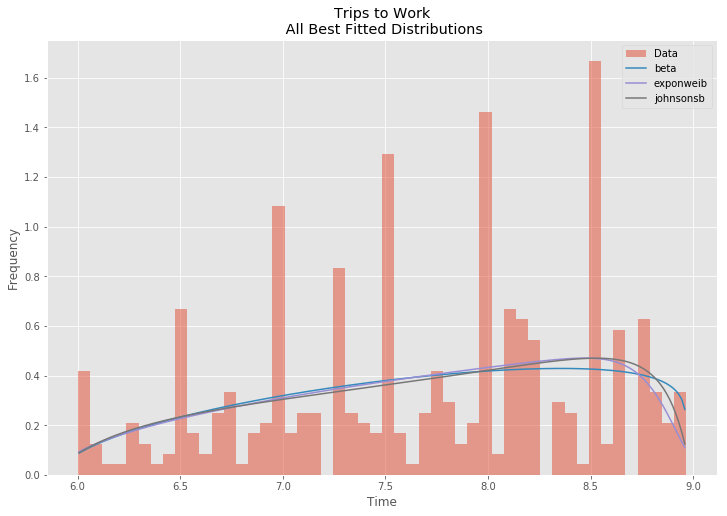

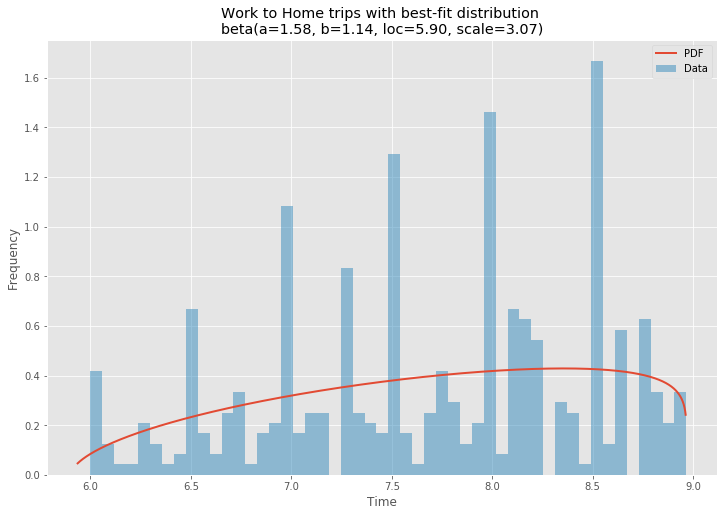

In [141]:
# # Load data
data = HW14

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution14(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'HW14 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For HW22
def best_fit_distribution22(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
#         st.recipinvgauss,
#         st.exponpow,
#         st.gengamma,
#         st.ncx2,
#         st.powerlaw,
#         st.johnsonsb,
#         st.exponweib,
#         st.beta,
        st.weibull_min,
        st.exponnorm,
        st.norm,
        st.burr12,
        st.burr,
        st.gilbrat,
        st.lognorm,
        st.rayleigh,
        st.pareto,
        st.halfgennorm,
#         st.gausshyper,        
#         st.anglit,
#         st.weibull_max,
#         st.mielke,
#         st.vonmises_line,
        st.gompertz,
        st.fatiguelife,
#         st.semicircular,
        st.triang
        
#         st.genlogistic,
#         st.pearson3,
#         st.loggamma
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

Text(0,0.5,'Frequency')

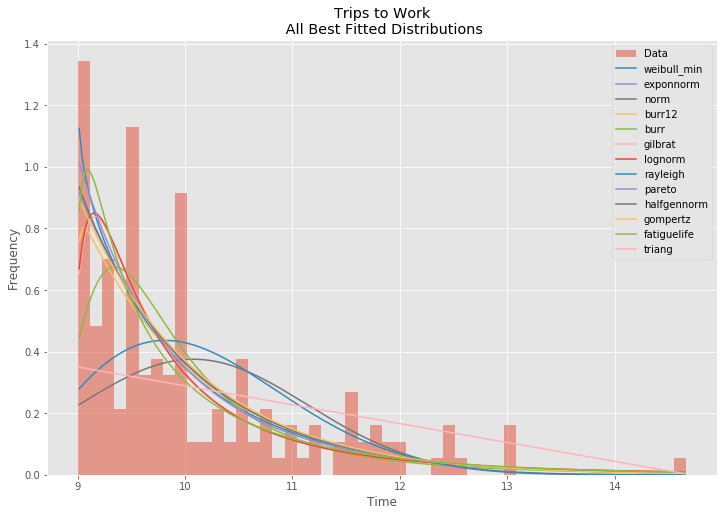

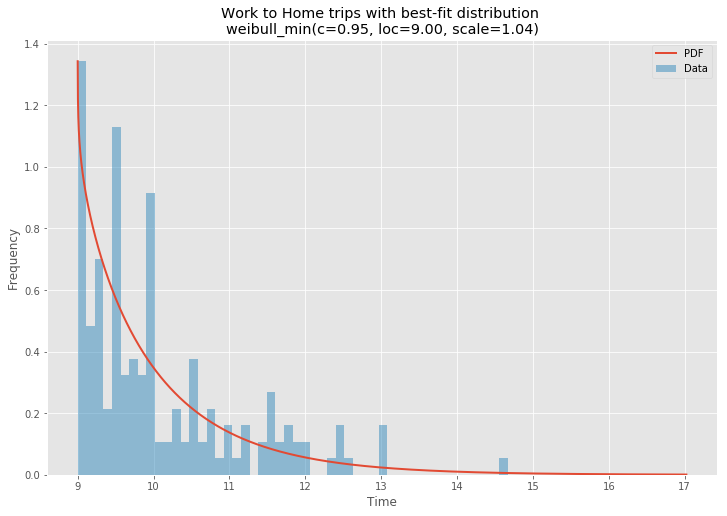

In [170]:
# # Load data
data = HW22

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution22(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'HW22 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For HW23
def best_fit_distribution23(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
#         st.recipinvgauss,
#         st.exponpow,
#         st.gengamma,
#         st.ncx2,
#         st.powerlaw,
#         st.johnsonsb,
#         st.exponweib,
#         st.beta,
        
#         st.weibull_min,
#         st.halfgennorm,
#         st.gengamma,
        st.kappa3,

        st.levy,


#         st.arcsine,
#         st.wald,
#         st.powernorm,
#         st.exponnorm,

#         st.burr12,
#         st.burr,
#         st.gilbrat,
# #         st.lognorm,
#         st.pareto,
        st.invweibull,
#         st.wrapcauchy,

# #         st.gausshyper,        
# #         st.anglit,
# #         st.weibull_max,
# #         st.mielke,
# #         st.vonmises_line,
#         st.gompertz,
#         st.semicircular,

        
#         st.genlogistic,
#         st.pearson3,
#         st.loggamma
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

Text(0,0.5,'Frequency')

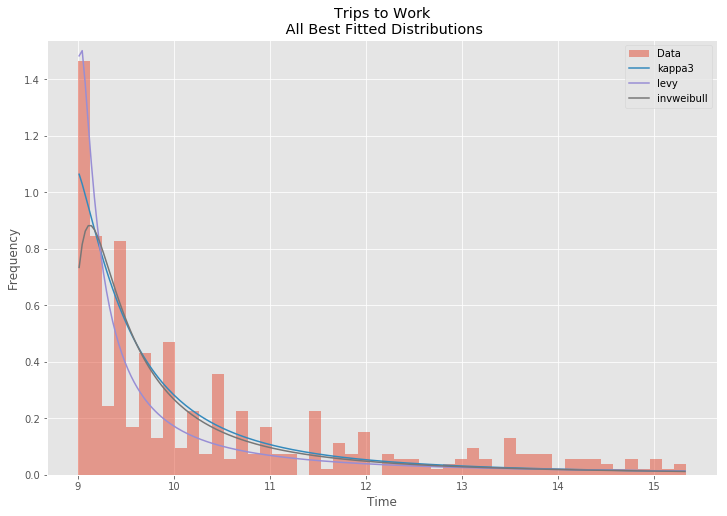

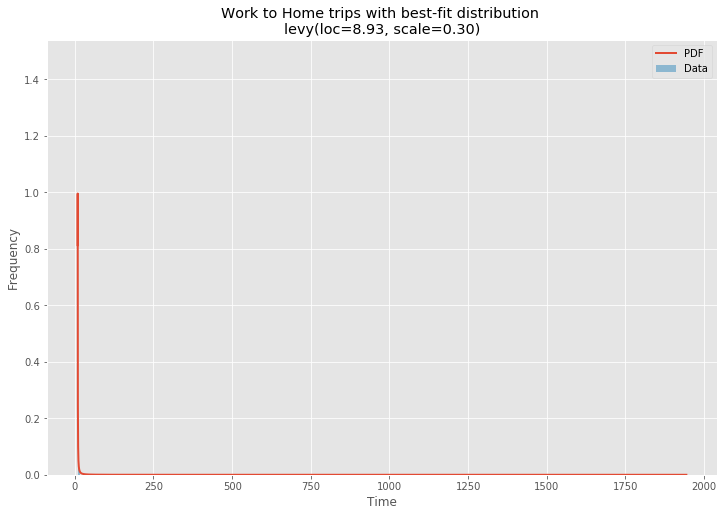

In [199]:
# # Load data
data = HW23

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution23(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'HW23 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For HW24a
def best_fit_distributionHW24a(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  

#         st.pearson3,
        st.bradford,
        st.levy,
        
        st.powerlognorm,
        st.pareto,
        
        st.fatiguelife,
        st.halfgennorm,
        st.vonmises,
        st.halflogistic,
        st.expon,
        
        st.lognorm,
        st.burr12,
        
        st.fisk,
        st.exponnorm,
        st.invgauss,
        
        st.gilbrat,
        st.wald,
        st.powernorm,
        st.gompertz,
        st.expon,
        st.genexpon,
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

bradford(c=9.63, loc=9.00, scale=2.83)


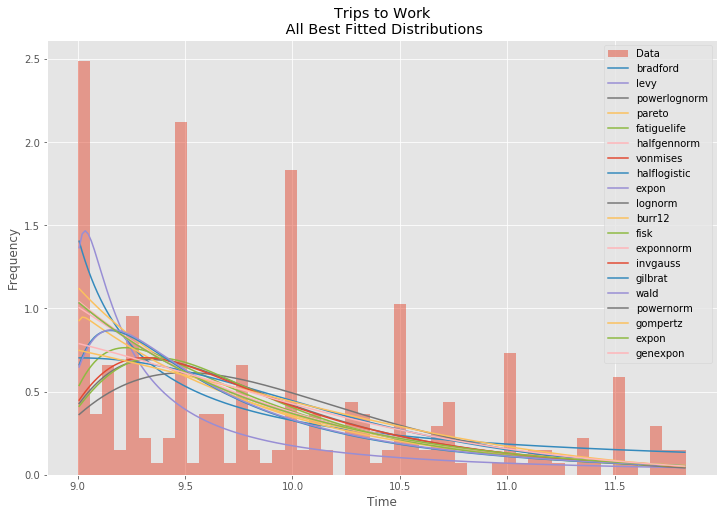

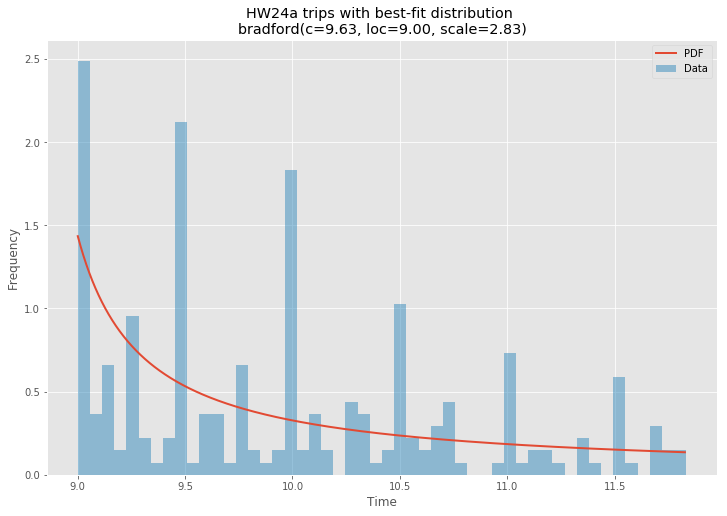

In [406]:
# # Load data
data = HW24a

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distributionHW24a(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'HW24a trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

exponweib(a=0.05, c=21.50, loc=11.99, scale=3.23)


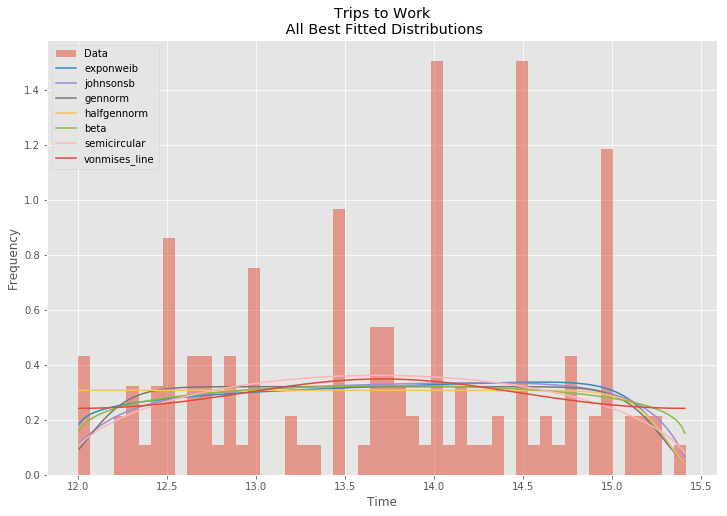

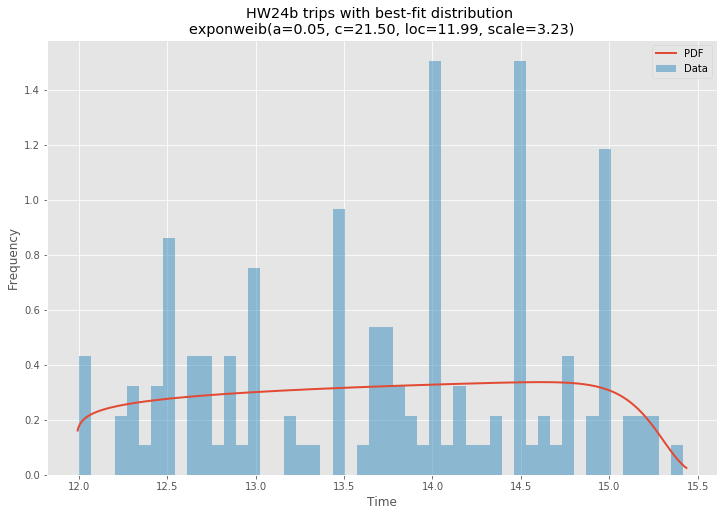

In [436]:
# # Load data
data = HW24b

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distributionHW24b(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'HW24b trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [435]:
#For HW24b
def best_fit_distributionHW24b(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
        
        st.exponweib,
        st.johnsonsb,
        st.gennorm,
        st.halfgennorm,
        st.beta,
        st.semicircular,   
        st.vonmises_line,
        
#         st.argus,
#         st.genextreme,
#         st.invgamma,
#         st.vonmises,
       
#         st.anglit,
#         st.gompertz,
#         st.fatiguelife,
#         st.powerlaw,
        
#         st.burr,
#         st.gumbel_l,
#         st.pearson3,
        
#         st.foldnorm,
#         st.skewnorm,
#         st.mielke,
#         st.triang
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

In [405]:
#For HW24a
def best_fit_distributionHW24a(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  

#         st.pearson3,
        st.bradford,
        st.levy,
        
        st.powerlognorm,
        st.pareto,
        
        st.fatiguelife,
        st.halfgennorm,
        st.vonmises,
        st.halflogistic,
        st.expon,
        
        st.lognorm,
        st.burr12,
        
        st.fisk,
        st.exponnorm,
        st.invgauss,
        
        st.gilbrat,
        st.wald,
        st.powernorm,
        st.gompertz,
        st.expon,
        st.genexpon,
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

In [ ]:
#For HW24
def best_fit_distribution24(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
#         st.pearson3,
        st.gengamma,
        st.gausshyper,        
        

#         st.halfgennorm,
# #         st.gengamma,
#         st.kappa3,
#         st.expon,
#         st.halflogistic,
        st.levy,
#         st.invgauss,
#         st.foldcauchy,
# #         st.arcsine,
#         st.wald,
#         st.powernorm,
#         st.powerlognorm,
#         st.exponnorm,
        st.fatiguelife,
#         st.genexpon,
# #         st.burr12,
#         st.burr,
# #         st.gilbrat,
#         st.lognorm,
        st.pareto,
#         st.invweibull,
# #         st.wrapcauchy,
        
# # #         st.anglit,
# # #         st.weibull_max,
# # #         st.mielke,
#         st.vonmises,
        st.gompertz,
# #         st.semicircular,

        
# #         st.genlogistic,

# #         st.loggamma
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

Text(0,0.5,'Frequency')

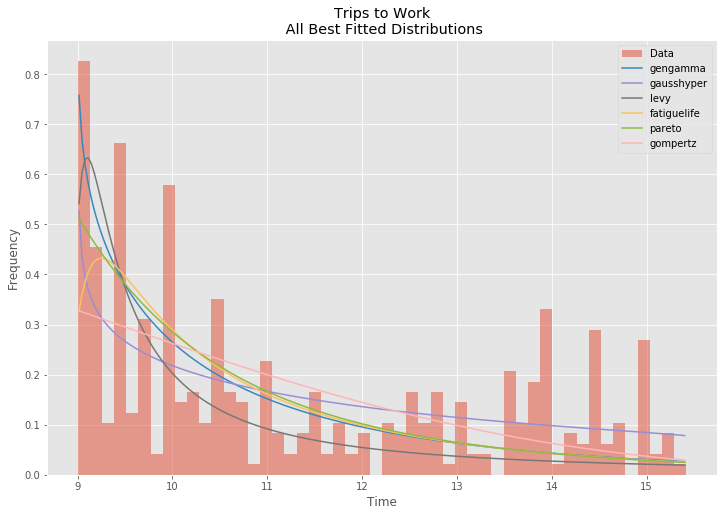

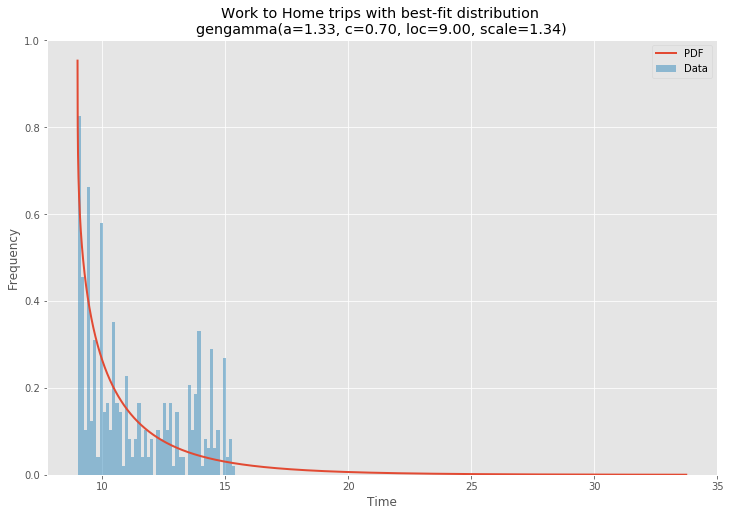

In [222]:
# # Load data
data = HW24

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution24(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'HW24 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For WH02
def best_fit_distributionWH02(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  

#         st.argus,
        st.burr,
        st.genextreme,
        st.invgamma,
        st.genlogistic,
        st.genhalflogistic,
        st.gumbel_l,
        st.johnsonsu,
        st.pearson3,
        st.levy_l,
        st.powerlaw
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

johnsonsu(a=6.24, b=1.21, loc=15.48, scale=0.01)


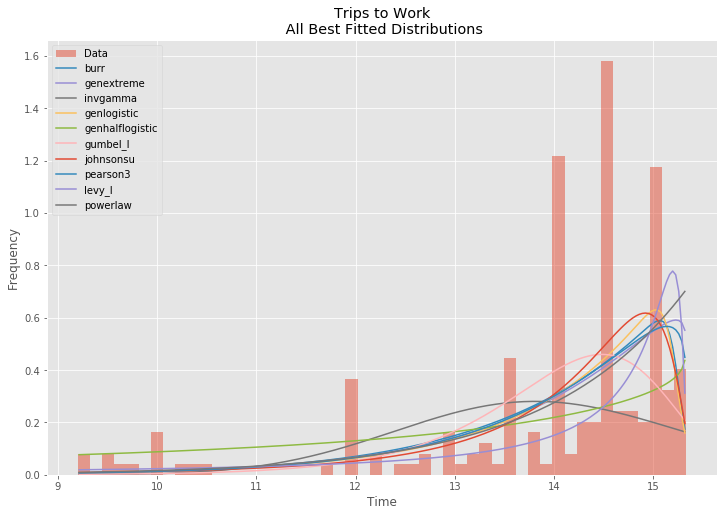

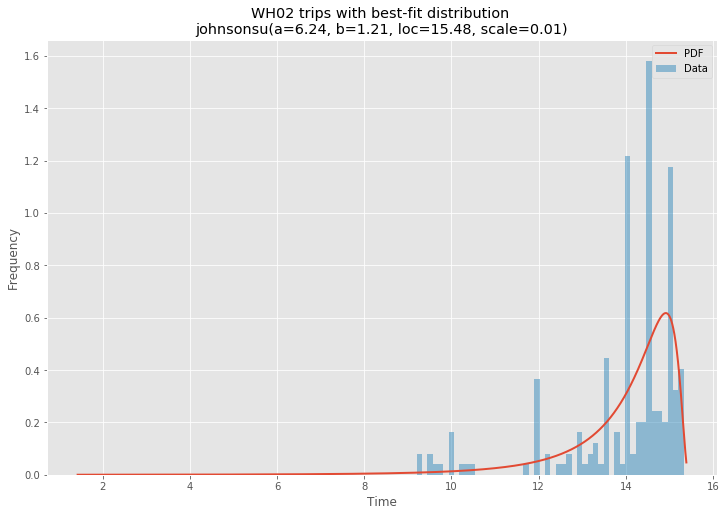

In [241]:
# # Load data
data = WH02

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distributionWH02(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'WH02 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For WH12
def best_fit_distributionWH12(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  

        st.burr,
        st.genlogistic,
        st.johnsonsb,
        st.pearson3,        
        st.powerlaw,
        st.levy_l

    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

johnsonsb(a=-0.95, b=0.71, loc=8.69, scale=6.80)


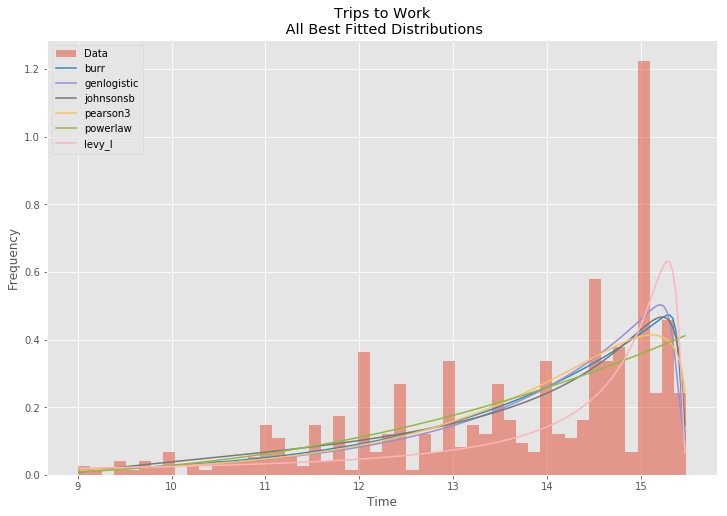

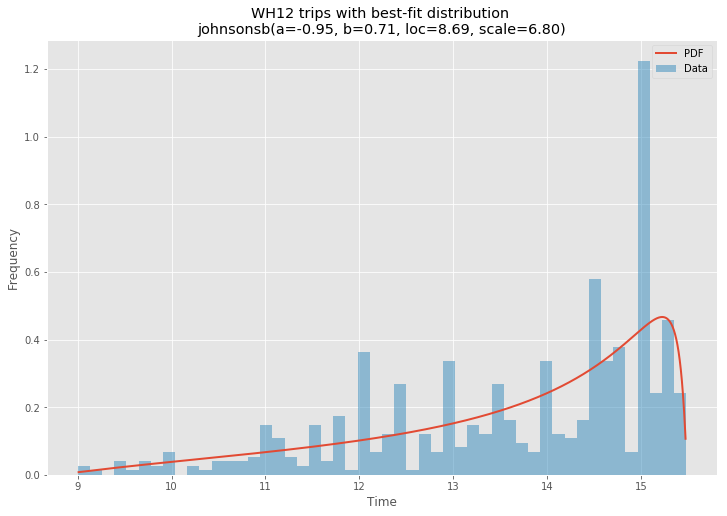

In [273]:
# # Load data
data = WH12

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distributionWH12(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'WH12 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For WH22
def best_fit_distributionWH22(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  

        st.burr,
        st.genlogistic,
        st.loggamma,
        st.johnsonsb,
        st.johnsonsu,
        st.pearson3,        
        st.powerlaw,
        st.levy_l

    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

burr(c=263.97, d=0.03, loc=-1.00, scale=16.33)


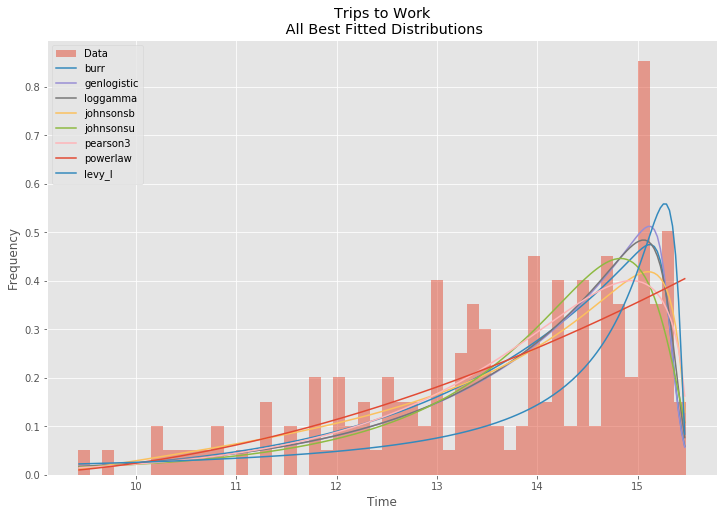

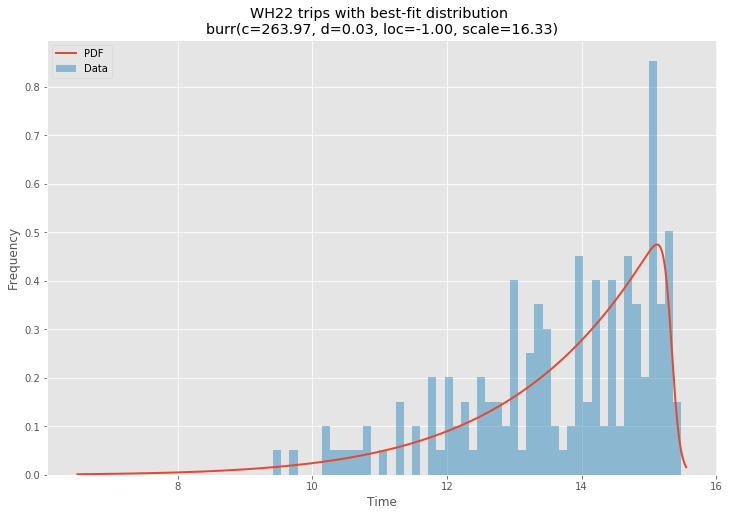

In [281]:
# # Load data
data = WH22

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distributionWH22(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'WH22 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For WH03
def best_fit_distributionWH03(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  

        st.burr,
        st.burr12,
        st.norm,
        st.exponnorm,
        st.anglit,
#         st.gibrat,
        st.lognorm,
#         st.pearson3,
        st.vonmises,
        st.wald,
        st.powernorm,
        st.powerlognorm,
        st.vonmises_line,
        st.bradford,
        st.genexpon,
        st.expon,
        st.halflogistic,
        st.halfgennorm,
        st.pareto,
        st.levy
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

bradford(c=8.91, loc=15.50, scale=3.01)


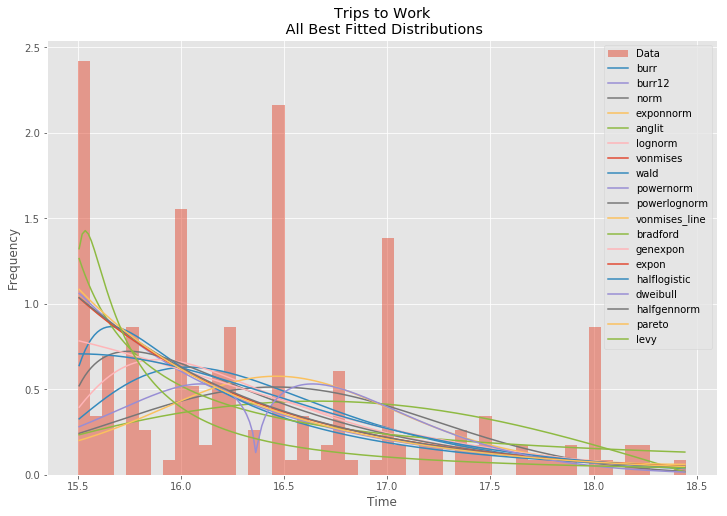

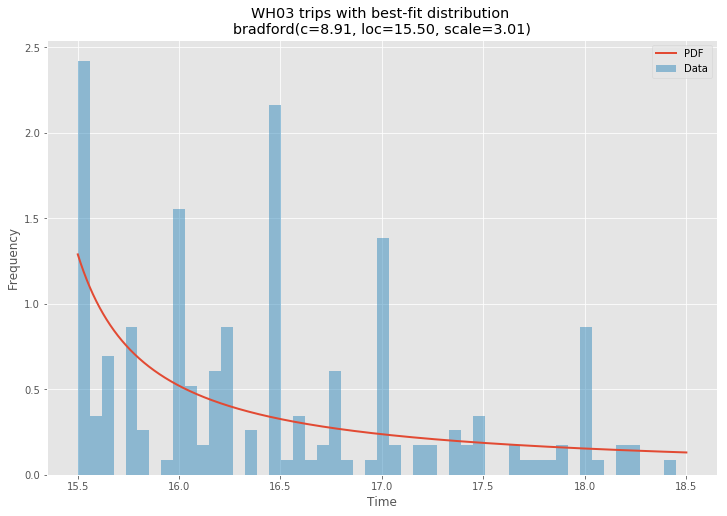

In [264]:
# # Load data
data = WH03

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution/
best_fit_name, best_fir_paramms = best_fit_distributionWH03(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'WH03 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [299]:
#For WH13
def best_fit_distributionWH13(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  
        
        st.vonmises_line,
        st.triang,
        st.genhalflogistic,
        st.foldnorm,
        st.skewnorm,
        st.johnsonsb,
        st.mielke,
        st.arcsine
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

vonmises_line(kappa=0.41, loc=16.99, scale=0.47)


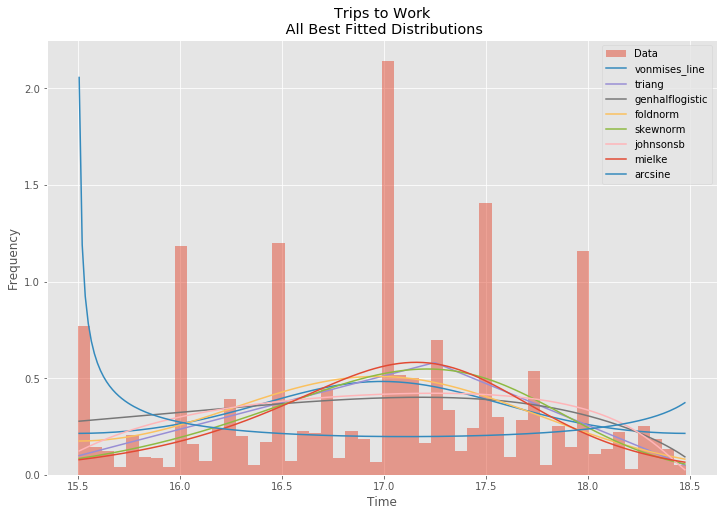

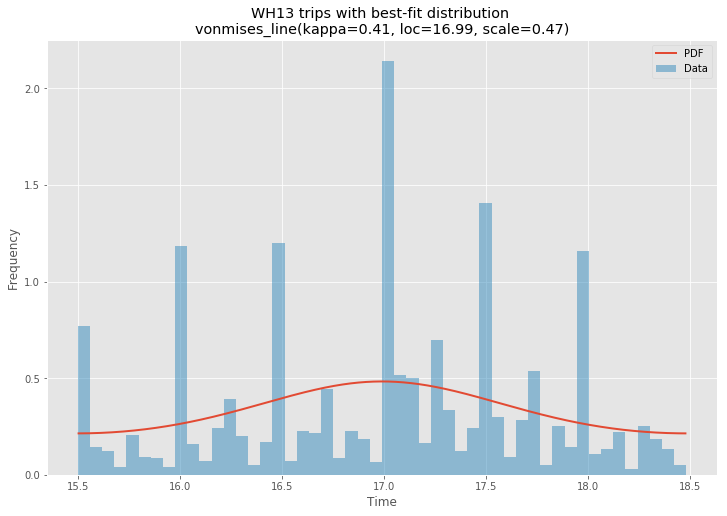

In [300]:
# # Load data
data = WH13

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution/
best_fit_name, best_fir_paramms = best_fit_distributionWH13(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'WH13 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For WH23
def best_fit_distributionWH23(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  

        st.triang,
        st.gengamma,
        st.exponweib,
        st.burr,
        st.exponpow,
        st.gumbel_l,
        st.genlogistic,
        st.mielke,
        st.pearson3,
        st.beta,
        st.levy_l
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

triang(c=0.90, loc=15.17, scale=3.34)


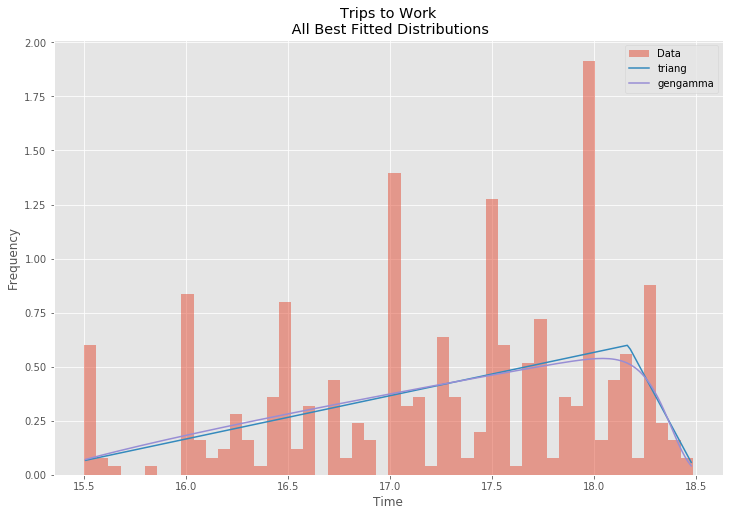

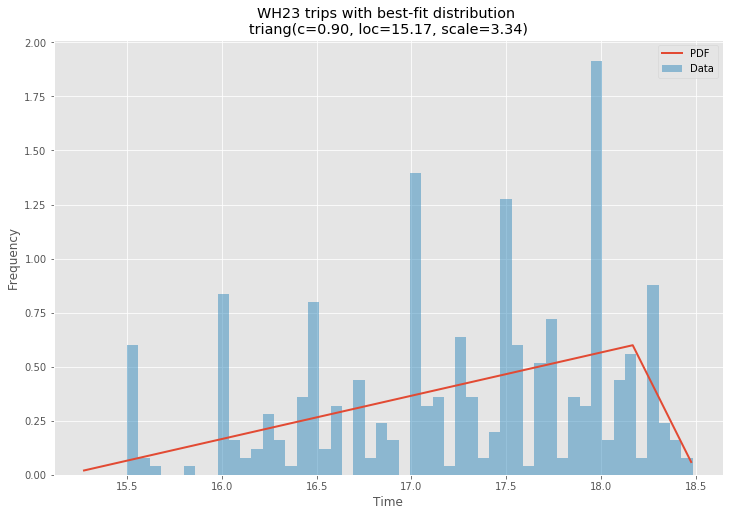

In [313]:
# # Load data
data = WH23

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution/
best_fit_name, best_fir_paramms = best_fit_distributionWH23(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'WH23 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For WH14
def best_fit_distributionWH14(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  

#         st.fatiguelife,
#         st.chi,
        st.alpha,
        st.f,
        st.exponnorm,
        st.invgauss,
        st.invgamma,
        st.gilbrat,
        st.wald,
        st.powernorm,
        st.gompertz,
        st.genexpon,
        st.pareto,
        st.levy_l
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

pareto(b=19.93, loc=-0.36, scale=18.86)


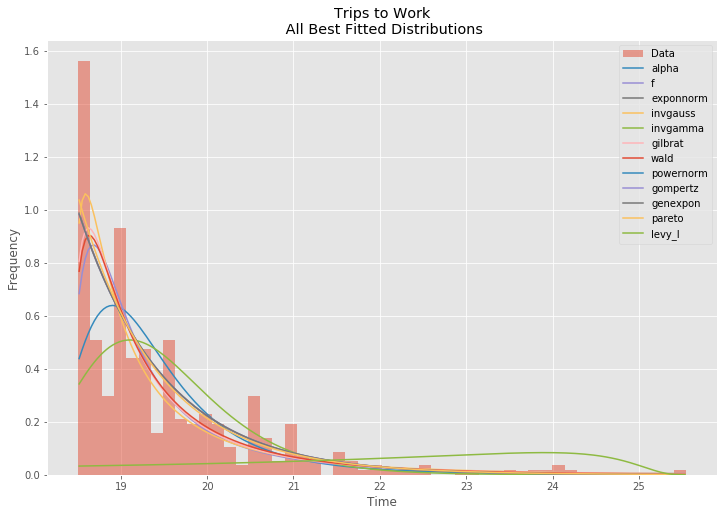

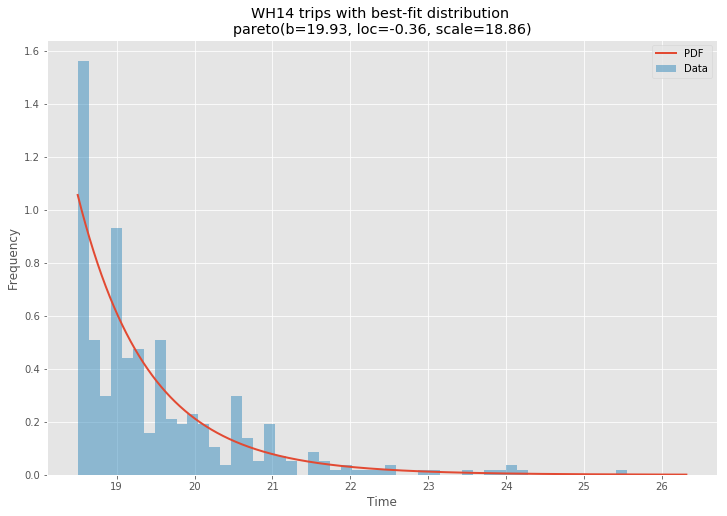

In [339]:
# # Load data
data = WH14

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution/
best_fit_name, best_fir_paramms = best_fit_distributionWH14(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'WH14 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

In [ ]:
#For WH24
def best_fit_distributionWH24(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [  

        st.bradford,
        st.beta,
        
        st.pearson3,
        st.powerlognorm,
        st.johnsonsb,
        st.weibull_min,
        st.pareto,
        
#         st.fatiguelife,
#         st.halfgennorm,
#         st.vonmises,
#         st.halflogistic,
        
#         st.lognorm,
#         st.burr12,
#         st.erlang,
        
#         st.fisk,
#         st.exponnorm,
#         st.invgauss,
        
#         st.gilbrat,
#         st.wald,
#         st.powernorm,
#         st.gompertz,
#         st.expon,
#         st.genexpon,
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax, label=distribution.name,legend=True)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

bradford(c=21.60, loc=18.50, scale=7.76)


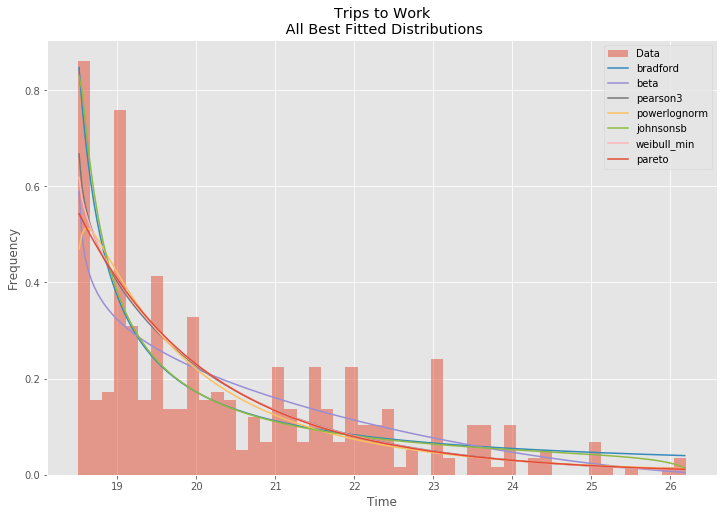

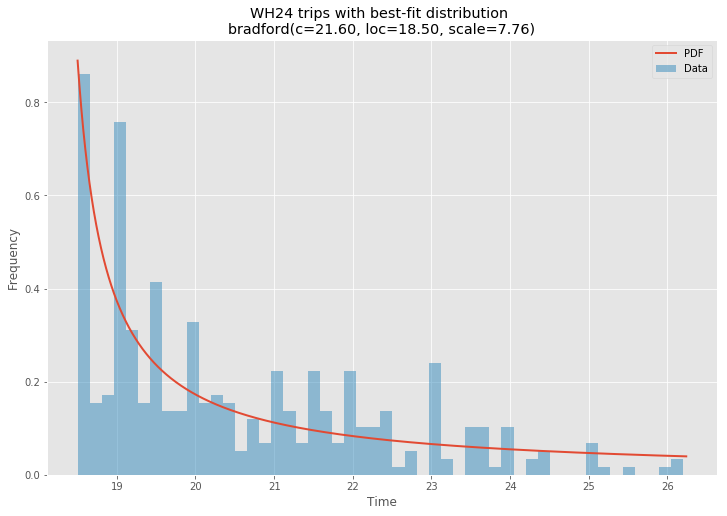

In [377]:
# # Load data
data = WH24

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True
               #, color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution/
best_fit_name, best_fir_paramms = best_fit_distributionWH24(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Trips to Work\n All Best Fitted Distributions')
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'WH24 trips with best-fit distribution \n' + dist_str)
ax.set_xlabel(u'Time')
ax.set_ylabel('Frequency')

print (dist_str)

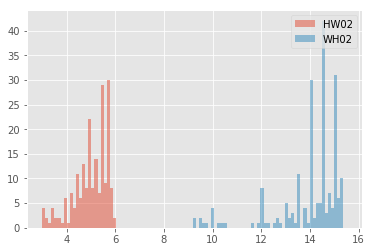

<Figure size 1440x864 with 0 Axes>

In [442]:
x = HW02
y = WH02

bins = np.linspace(3, 15.5, 100)

plt.hist(x, bins, alpha=0.5, label='HW02')
plt.hist(y, bins, alpha=0.5, label='WH02')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

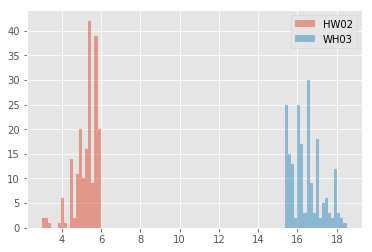

<Figure size 1440x864 with 0 Axes>

In [443]:
x = HW03
y = WH03

bins = np.linspace(3, 18.5, 100)

plt.hist(x, bins, alpha=0.5, label='HW02')
plt.hist(y, bins, alpha=0.5, label='WH03')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

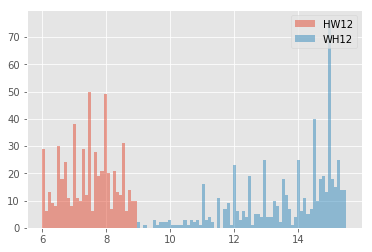

<Figure size 1440x864 with 0 Axes>

In [444]:
x = HW12
y = WH12

bins = np.linspace(6, 15.5, 100)

plt.hist(x, bins, alpha=0.5, label='HW12')
plt.hist(y, bins, alpha=0.5, label='WH12')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

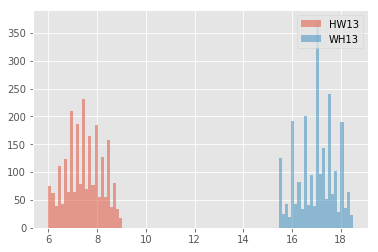

<Figure size 1440x864 with 0 Axes>

In [445]:
x = HW13
y = WH13

bins = np.linspace(6, 18.5, 100)

plt.hist(x, bins, alpha=0.5, label='HW13')
plt.hist(y, bins, alpha=0.5, label='WH13')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

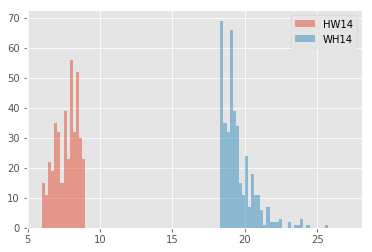

<Figure size 1440x864 with 0 Axes>

In [446]:
x = HW14
y = WH14

bins = np.linspace(6, 27, 100)

plt.hist(x, bins, alpha=0.5, label='HW14')
plt.hist(y, bins, alpha=0.5, label='WH14')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

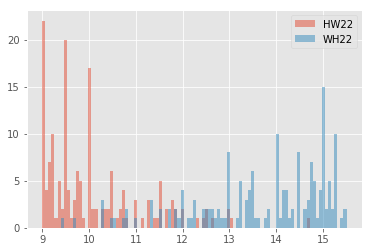

<Figure size 1440x864 with 0 Axes>

In [447]:
x = HW22
y = WH22

bins = np.linspace(9, 15.5, 100)

plt.hist(x, bins, alpha=0.5, label='HW22')
plt.hist(y, bins, alpha=0.5, label='WH22')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

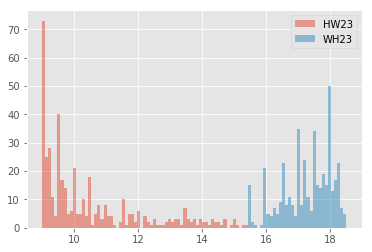

<Figure size 1440x864 with 0 Axes>

In [448]:
x = HW23
y = WH23

bins = np.linspace(9, 18.5, 100)

plt.hist(x, bins, alpha=0.5, label='HW23')
plt.hist(y, bins, alpha=0.5, label='WH23')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

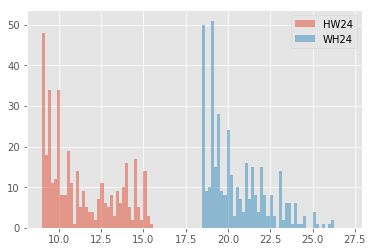

<Figure size 1440x864 with 0 Axes>

In [449]:
x = HW24
y = WH24

bins = np.linspace(9, 27, 100)

plt.hist(x, bins, alpha=0.5, label='HW24')
plt.hist(y, bins, alpha=0.5, label='WH24')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()

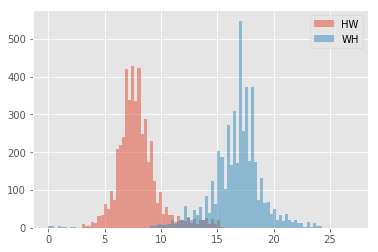

<Figure size 1440x864 with 0 Axes>

In [450]:
x = HW
y = WH

bins = np.linspace(0, 27, 100)

plt.hist(x, bins, alpha=0.5, label='HW')
plt.hist(y, bins, alpha=0.5, label='WH')
plt.legend(loc='upper right')
plt.figure(figsize=(20,12))
plt.show()